project:
- write a script that can take 2 drivers and plot their cumulative points per round in a line graph for a whole season
- and if possible, plot a bar chart of points per race below



In [1]:
##IMPORTS

import requests
import json
import fastf1 as ff1
from fastf1 import plotting
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
from matplotlib.collections import LineCollection
from scipy.interpolate import make_interp_spline, BSpline

import pandas as pd
import numpy as np
import random

import seaborn as sns

# Setup plotting
plotting.setup_mpl()
# Enable the cache
ff1.Cache.enable_cache('cache')

In [8]:
#DRIVER DETAILS


season = '2021'
driver_1 = 'LEC'
driver_2 = 'SAI'
rounds = 22


#GET DATA
    ### Cumulative Points
def ergast_retrieve(api_endpoint: str):
    url = f'https://ergast.com/api/f1/{api_endpoint}.json'
    response = requests.get(url).json()
    
    return response['MRData']


# Initiate an empty dataframe to store our data
all_championship_standings = pd.DataFrame()

# We also want to store which driver drives for which team, which will help us later
driver_team_mapping = {}

# Initate a loop through all the rounds
for i in range(1, rounds + 1):
    # Make request to driverStandings endpoint for the current round
    race = ergast_retrieve(f'{season}/{i}/driverStandings')
    
    # Get the standings from the result
    standings = race['StandingsTable']['StandingsLists'][0]['DriverStandings']
    
    # Initiate a dictionary to store the current rounds' standings in
    current_round = {'round': i}
    
    # Loop through all the drivers to collect their information
    for i in range(len(standings)):
        driver = standings[i]['Driver']['code']
        points = standings[i]['points']
        
        # Store the drivers' points for round
        current_round[driver] = points
        
        # Create mapping for driver-team to be used for the coloring of the lines
        driver_team_mapping[driver] = standings[i]['Constructors'][0]['name']


    # Append the current round to our fial dataframe
    all_championship_standings = all_championship_standings.append(current_round, ignore_index=True)
    
# Set the round as the index of the dataframe
all_championship_standings = all_championship_standings.set_index('round')



all_championship_standings_melted = pd.melt(all_championship_standings.reset_index(), ['round'])


### Points at Race




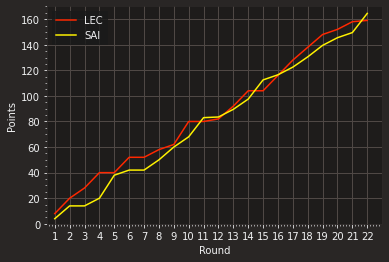

In [9]:


# Plot formatting

fig, ax = plt.subplots()
ax.set_xticks(range(1, rounds +1))
ax.set_xlim(0.5,23)
ax.set_ylim(0,170)
ax.set_xlabel("Round")
ax.set_ylabel("Points")
ax.grid(visible=True, which='major')
ax.grid(visible=False, which='minor')

### CUMULATIVE PLOTTING

driver_1_c_pts = all_championship_standings[driver_1].astype('float64')
driver_2_c_pts = all_championship_standings[driver_2].astype('float64')
ax.plot(driver_1_c_pts, label=driver_1, color='#ff2800')
ax.plot(driver_2_c_pts, label=driver_2, color='#fff200')

#ax.vlines(11.5,-1,300,color='grey',linestyles='dotted')

### PER ROUND PLOTTING



###
plt.legend(loc="upper left")
#plt.savefig('LECvSAI_c_pts_v2.png', dpi=300)

plt.show()


round
1.0      4.0
2.0      6.0
3.0     14.0
4.0     20.0
5.0      2.0
6.0     10.0
7.0     10.0
8.0      8.0
9.0      2.0
10.0    12.0
11.0    -3.0
12.0    -1.5
13.0     2.5
14.0     6.5
15.0    -8.5
16.0    -0.5
17.0     5.5
18.0     7.5
19.0     8.5
20.0     6.5
21.0     8.5
22.0    -5.5
dtype: float64
[4.0, 6.0, 14.0, 20.0, 2.0, 10.0, 10.0, 8.0, 2.0, 12.0, -3.0, -1.5, 2.5, 6.5, -8.5, -0.5, 5.5, 7.5, 8.5, 6.5, 8.5, -5.5]


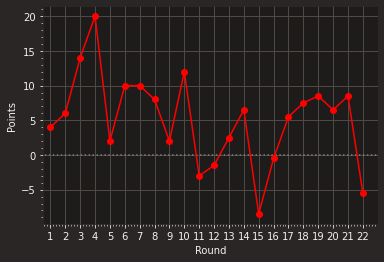

In [10]:
deficit = driver_1_c_pts - driver_2_c_pts
print(deficit)

deficit_list = pd.Series.tolist(deficit)
print(deficit_list)

fig, ax = plt.subplots()
ax.set_xticks(range(1, rounds +1))
ax.set_xlim(0.5,23)
#ax.set_ylim(-21,21)
ax.set_xlabel("Round")
ax.set_ylabel("Points")
ax.grid(visible=True, which='major')
ax.grid(visible=False, which='minor')
ax.hlines(0,-1,30,color='grey',linestyles='dotted')

ax.plot(deficit, 'r')
ax.plot(deficit, 'ro')
plt.show()

[[[ 1.          4.        ]
  [ 1.02102102  3.97575765]]

 [[ 1.02102102  3.97575765]
  [ 1.04204204  3.95436187]]

 [[ 1.04204204  3.95436187]
  [ 1.06306306  3.93581265]]

 ...

 [[21.93693694 -4.03660549]
  [21.95795796 -4.5157208 ]]

 [[21.95795796 -4.5157208 ]
  [21.97897898 -5.00351896]]

 [[21.97897898 -5.00351896]
  [22.         -5.5       ]]]


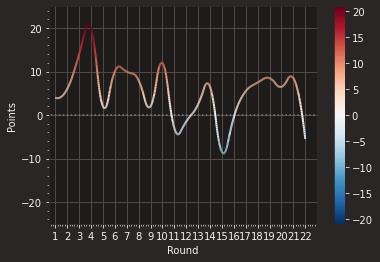

In [11]:
x = range(1, rounds +1)
y = deficit

fig, ax = plt.subplots()
ax.set_xticks(range(1, rounds +1))
ax.set_xlim(0.5,rounds +1)

if y.max() >= -y.min():
    ax.set_ylim(-y.max()-5,y.max()+5)
else:
    ax.set_ylim(y.min()-5,-y.min()+5)






ax.set_xlabel("Round")
ax.set_ylabel("Points")
ax.grid(visible=True, which='major')
ax.grid(visible=False, which='minor')
ax.hlines(0,-1,30,color='grey',linestyles='dotted')



# 300 represents number of points to make between T.min and T.max
xnew = np.linspace(1, rounds, 1000) 

spl = make_interp_spline(x, y, k=2)  # type: BSpline
y_smooth = spl(xnew)

points = np.array([xnew, y_smooth]).T.reshape(-1, 1, 2)
#print(points)
segments = np.concatenate([points[:-1], points[1:]], axis=1)
print(segments)

norm = plt.Normalize(-y_smooth.max(), y_smooth.max())
lc = LineCollection(segments, cmap='RdBu_r', norm=norm)
# Set the values used for colormapping
lc.set_array(y_smooth)
lc.set_linewidth(2)
line = ax.add_collection(lc)
fig.colorbar(line, ax=ax)


#plt.savefig('SAIvLEC_deficit.png', dpi=300)

Text(19, -12, 'SAI +6.5pts')

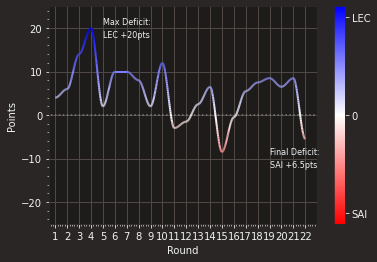

In [13]:
x = range(1, rounds +1)
y = deficit

fig, ax = plt.subplots()
ax.set_xticks(range(1, rounds +1))
ax.set_xlim(0.5,rounds +1)

if y.max() >= -y.min():
    ax.set_ylim(-y.max()-5,y.max()+5)
else:
    ax.set_ylim(y.min()-5,-y.min()+5)

ax.set_xlabel("Round")
ax.set_ylabel("Points")
ax.grid(visible=True, which='major')
ax.grid(visible=False, which='minor')
ax.hlines(0,-1,30,color='grey',linestyles='dotted')

from scipy.interpolate import CubicHermiteSpline

cs = CubicHermiteSpline(x, y, np.zeros(len(x))) # force gradient to zero
xs = np.linspace(min(x), max(x), num=1000)

points = np.array([xs, cs(xs)]).T.reshape(-1, 1, 2)
segments = np.concatenate([points[:-1], points[1:]], axis=1)

norm = plt.Normalize(-cs(xs).max(), cs(xs).max())
lc = LineCollection(segments, cmap='bwr_r', norm=norm)

lc.set_array(cs(xs))
lc.set_linewidth(2)
line = ax.add_collection(lc)
cbar = fig.colorbar(line, ax=ax, ticks=[-18, 0, 18])
cbar.ax.set_yticklabels(['SAI','0', 'LEC'])

#ax.plot(xs, cs(xs))

#ax.plot(xs, cs(xs), color='r')
#ax.plot(x, y, markersize=4)

ax.text(5, 21, r'Max Deficit:', fontsize=8)
ax.text(5, 18, r'LEC +20pts', fontsize=8)
ax.text(19, -9, r'Final Deficit:', fontsize=8)
ax.text(19, -12, r'SAI +6.5pts', fontsize=8)




#plt.savefig('SAIvLEC_deficit.png', dpi=300)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import CubicHermitSpline

fig, ax = plt.subplots()

x = [1,2,3,4,5,6,7,8,9,10]
y = [8,2,1,7,5,5,8,1,9,5]

cs = CubicHermiteSpline(x, y, np.zeros(len(x)))
xs = np.linspace(min(x), max(x), num=100)

ax.plot(xs, cs(xs))

In [ ]:
fig, ax = plt.subplots()
ax.set_xticks(range(1, rounds +1))

for driver in all_championship_standings:
    driver_c_pts = all_championship_standings[driver].astype('float64')
    ax.plot(driver_c_pts, label=driver)
    
plt.legend(loc='lower center', ncol=5, bbox_to_anchor=(0.45,-0.5))
plt.show